# Clinvar plots

## Preliminaries

### Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Style and colors

In [2]:
# Choose style sheet(s)
plt.style.use("plot_styles/default.mplstyle")

# Import functions from the _color_tools notebook
%run _color_tools.ipynb

# Assign the color palette to a variable.
# Individual colors can be selected by index (e.g. C[0])
C = sns.color_palette().as_hex()
sns.color_palette()

[(0.0, 0.4666666666666667, 0.7333333333333333),
 (0.0, 0.6, 0.5333333333333333),
 (0.9333333333333333, 0.4666666666666667, 0.2),
 (0.8, 0.2, 0.06666666666666667),
 (0.2, 0.7333333333333333, 0.9333333333333333),
 (0.9333333333333333, 0.2, 0.4666666666666667),
 (0.7333333333333333, 0.7333333333333333, 0.7333333333333333),
 (0.0, 0.0, 0.0)]

### Load data

In [3]:
df = pd.read_csv("../outputs/clinvar_variants_lof_with_nmd_annotation.tsv", sep="\t")

## Plot the proportion of VUS by NMD annotation

In [4]:
# Data
region_order = ["nmd", "start_proximal", "long_exon", "distal"]
region_labels = ["NMD target", "Start-proximal", "Long exon", "Distal"]

## Data for Axes 1
data = df.groupby("variant_region")["acmg"].value_counts(normalize=True)

p = data.xs("P/LP", level="acmg")[region_order]
v = data.xs("VUS", level="acmg")[region_order]
b = data.xs("B/LB", level="acmg")[region_order]

## Data for Axes 2
exp = [0.613, 0.088, 0.087, 0.232]  # Genomic footprint of NMD regions
obs = df["variant_region"].value_counts(normalize=True)[region_order]

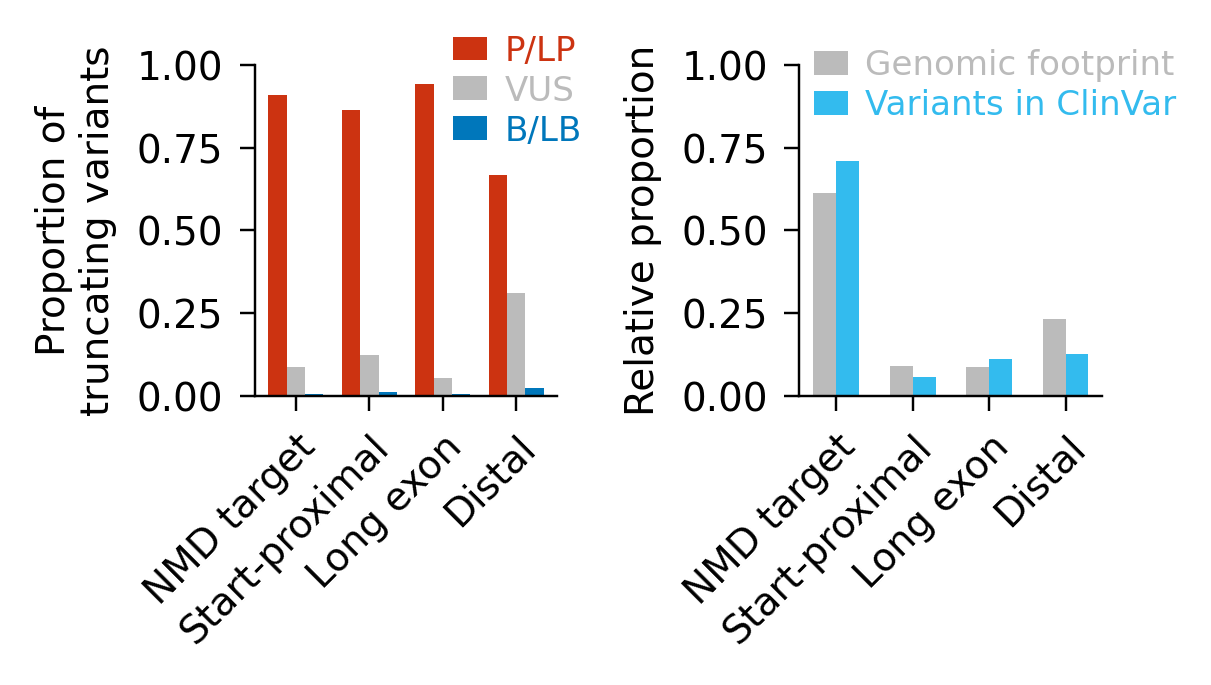

In [5]:
# Figure and colour scheme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5, 2), layout="tight",)
col = sns.color_palette("colorblind").as_hex()

# Axes 1
ticks = np.arange(len(p))
width = 0.25

ax1.bar(x=ticks, height=p, width=width, color=C[3], label="P/LP")
ax1.bar(x=ticks + width, height=v, width=width, color=C[-2], label="VUS")
ax1.bar(x= (ticks + 2 * width), height=b, width=width, color=C[0], label="B/LB")

ax1.set_xlabel(None)
ax1.set_ylabel("Proportion of\ntruncating variants")
ax1.set_xticks(
    ticks=(ticks + width),
    labels=["NMD target", "Start-proximal", "Long exon", "Distal"],
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax1.set_yticks(ticks=[0, 0.25, 0.5, 0.75, 1])
ax1.set_ylim(0, 1)
ax1.legend(
    title=None,
    loc="lower left",
    bbox_to_anchor=(0.6,0.7)
)

# Axes 2
ticks = np.arange(len(exp))
width = 0.3

ax2.bar(x=ticks, height=exp, width=width, color=C[-2], label="Genomic footprint")
ax2.bar(
    x=ticks + width, height=obs, width=width, color=C[4], label="Variants in ClinVar"
)

ax2.set_xticks(
    ticks=(ticks + width / 2),
    labels=region_labels,
    rotation=45,
    ha="right",
    rotation_mode="anchor",
)
ax2.set_yticks(ticks=[0, 0.25, 0.5, 0.75, 1])
ax2.set_ylabel("Relative proportion")

ax2.legend(
    loc="upper right",
    bbox_to_anchor=(1.3, 1.1)
)

plt.savefig("../plots/clinvar_variants_by_region.svg", format="svg")

## Reformat the data to long-form

In [6]:
dfa = df.melt(
    id_vars=["enst", "variant_region", "acmg"],
    value_vars=["gnomad", "nmd", "distal", "long_exon"],
    var_name="constraint_region",
    value_name="constraint",
)

### Filter ClinVar variants 
Keep those which:
- Fall in a transcript with a gnomAD constraint annotation
- Are in a region with a constraint annotation

In [7]:
m1 = dfa.constraint_region == "gnomad"
m2 = dfa.variant_region == dfa.constraint_region

dfa = dfa[m1 | m2].dropna()

### What proportion of variants are pathogenic / benign / VUS? 

In [8]:
prop = (
    dfa.groupby(["constraint_region", "constraint"])["acmg"]
    .value_counts(normalize=True)
    .reset_index(name="Proportion")
    .replace(
        {
            "gnomad": "gnomAD",
            "nmd": "NMD-target",
            "distal": "Distal",
            "long_exon": "Long exon",
            "tolerant": "Tolerant",
            "constrained": "Constrained",
        }
    )
    .rename(columns={"constraint": "Constraint", "acmg": "ACMG"})
)

## Plot the data

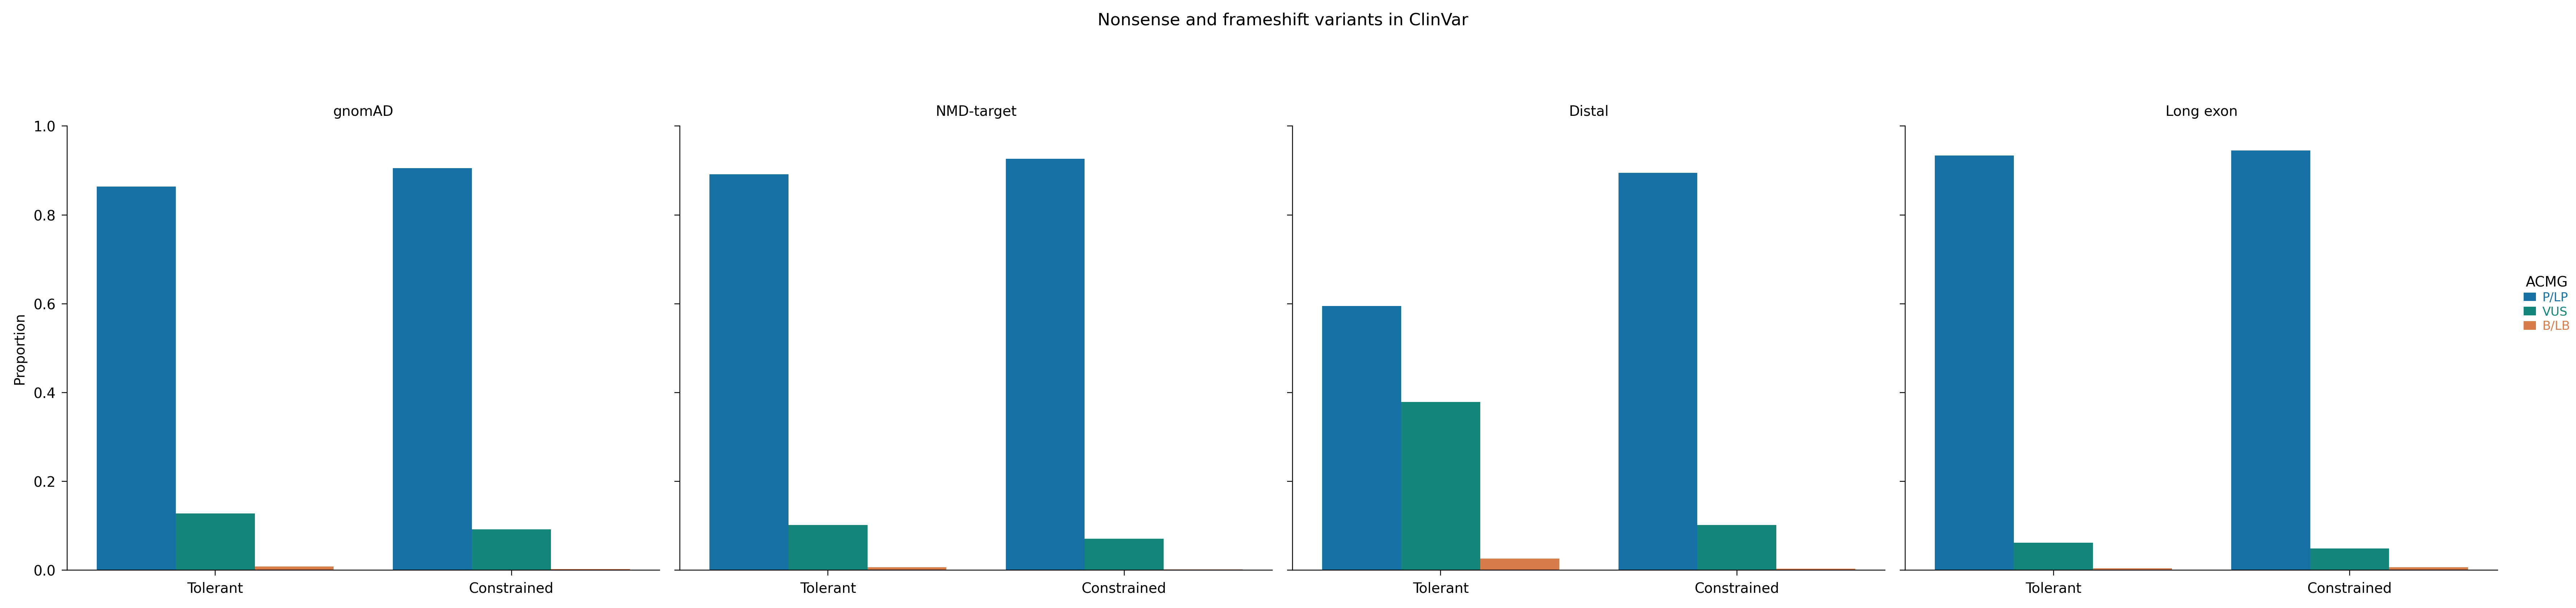

In [9]:
# Construct a bar plot

g = sns.catplot(
    kind="bar",
    data=prop,
    x="Constraint",
    order=["Tolerant", "Constrained"],
    hue="ACMG",
    hue_order=["P/LP", "VUS", "B/LB"],
    col="constraint_region",
    col_order=["gnomAD", "NMD-target", "Distal", "Long exon"],
    y="Proportion",
)
g.set(xlabel="", ylim=(0, 1))
g.set_titles(template="{col_name}")
g.fig.suptitle("Nonsense and frameshift variants in ClinVar")
g.fig.subplots_adjust(top=0.8)

## Tabulate the data

In [10]:
a = (
    dfa.groupby(["constraint_region", "constraint", "acmg"])
    .agg({"enst": "count"})
    .rename(columns={"enst": "Variant count"})
)
b = (
    dfa.groupby(["constraint_region", "constraint"])["acmg"]
    .value_counts(normalize=True)
    .rename("Proportion")
)

stats = (
    a.merge(b, left_index=True, right_index=True)
    .reset_index()
    .pivot(
        index="acmg",
        columns=["constraint_region", "constraint"],
        values=["Variant count", "Proportion"],
    )
    .swaplevel(0, 1, axis=1)
    .swaplevel(1, 2, axis=1)
    .sort_index(level=0, axis=1, sort_remaining=True)
)
stats

constraint_region      distal                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.003291          11.0   0.026493         244.0   
P/LP                 0.894973        2991.0   0.594680        5477.0   
VUS                  0.101735         340.0   0.378827        3489.0   

constraint_region      gnomad                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.002615          85.0   0.008368         593.0   
P/LP                 0.905388       29426.0   0.864044       61227.0   
VUS                  0.091997        2990.0   0.127588        9041.0   

constraint_region   long_exon                                         \
constraint        constrained                 tolerant                 
                   Proportion Variant count Proportion Variant count   
acmg                                                                   
B/LB                 0.006452          18.0   0.004582          30.0   
P/LP                 0.944803        2636.0   0.933568        6113.0   
VUS                  0.048746         136.0   0.061851         405.0   

constraint_region         nmd                                         
constraint        constrained                 tolerant                
                   Proportion Variant count Proportion Variant count  
acmg                                                                  
B/LB                 0.001927          52.0   0.006918         209.0  
P/LP                 0.926790       25015.0   0.891555       26933.0  
VUS                  0.071283        1924.0   0.101526        3067.0